# Tutorial and Sample Code for Balancing a Pole on a Cart

# Contributions:
*   Ng Hong Jin, Jonathan - Code Solver, Debugger
*  Jerick Lim Kai Zheng - Code Solver, Debugger
*  Oi Yeek Sheng - Code Solver, Debugger







## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#delete all the videos previously saved
%rm -rf video1
%rm -rf video2
%rm -rf sample_data

## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from sklearn.model_selection import GridSearchCV

def show_video(num):
  mp4list = glob.glob('video{}/*.mp4'.format(num))
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")


We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.00274788 -0.02926251 -0.04209393  0.00239187]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.00216263 -0.22375628 -0.0420461   0.28150213]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

Our agent utilises Q learning, and it chooses the action based on the Q-values of previously generated episodes.

In [ ]:
class CartPoleQAgent():
    def __init__(self,env=gym.make("CartPole-v1"), buckets=(1, 1, 6, 11), num_episodes=500, min_lr=0.1, max_lr=0.95, min_epsilon=0.1, max_epsilon=0.95, discount=1.0):
        #number of discrete states for each observation
        self.buckets = buckets
        #number of episodes trained
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.discount = discount
        self.env = env
        self.env._max_episode_steps = 1000

        #upper bound and lower bound of observation space[position, velocity, angle, angular velocity]
        self.upper_bounds = [4.8, 1. , 0.418 , 1.]
        self.lower_bounds = [-4.8, -1. , -0.418 , -1.]

        #array with shape (1,1,6,11,2) (action_space=2)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))


    #we need to discretize states (which are continuous variable) since otherwise, it would take forever to get values for each of the possible combinations of each state
    def discretize_state(self, obs):
        discretized_obs_list = list()
        for i in range(len(obs)):
            ranging = (obs[i] - self.lower_bounds[i]) / (self.upper_bounds[i] - self.lower_bounds[i])
            discretized_obs = int(round((self.buckets[i] - 1) * ranging))
            discretized_obs = min(self.buckets[i] - 1, max(0, discretized_obs))

            discretized_obs_list.append(discretized_obs)
        return tuple(discretized_obs_list)

    #Referenced 2)
    #Applying randomness on the next action using the epsilon value to avoid biasness from previous values generated from previous states
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    #Updating the value of the state action pair using the Q-learning formula
    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    #Reducing the value of epsilon after every iteration of training to incentivise the agent to take actions quickly
    def get_epsilon(self, t):
        range = self.max_epsilon - self.min_epsilon
        epsilon = self.max_epsilon - (t/self.num_episodes)*(range)
        return epsilon

    #Reducing the value of gamma after every iteration of training to incentivise the agent to take actions quickly
    def get_learning_rate(self, t):
        range = self.max_lr - self.min_lr
        lr = self.max_lr - (t/self.num_episodes)*(range)
        return lr
    
    #Referenced 2)
    #Training the model based on set number of episodes to repeatedly update the Q values in the Q table using the generated action
    def train(self):
        for e in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())
            done = False

            self.learning_rate = self.get_learning_rate(e)
            self.epsilon = self.get_epsilon(e)

            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state

        print('Finished training!')

    #Running the agent after training, with rendering to display the episodes in a video
    def run(self,render):
        if render:
          self.env = RecordVideo(gym.make("CartPole-v1",),"./video1")
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                if render:
                  self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
        
        if render: 
          self.env.close()
          version = 1
          show_video(version)
        return t

In [ ]:
agent = CartPoleQAgent()
agent.train()

Finished training!


For Task 1, we can show the observation and chosen action below:

In [ ]:
#Sampling a random state from the environment and outputting the observation and action chosen for that observation

current_state = agent.discretize_state(env.reset())
action = agent.choose_action(current_state)
print("Observation: ", observation)
print("Chosen Action: ", action)


Observation:  [-0.15077853 -1.9735093   0.23041947  2.9990351 ]
Chosen Action:  1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, we used the agent developed in Task 1 to play the game for 100 episodes and recorded the cumulative reward for each round, and plotted the reward for each round.

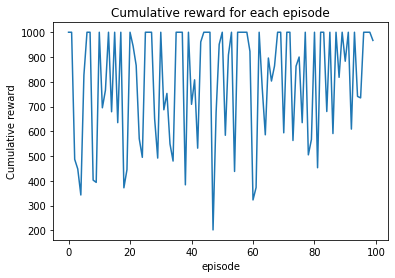

In [ ]:
#Initialising an array to store the different episodes generated
episode_results = []
showVideo = False
for i in range (100):
  episode_results.append(agent.run(showVideo))

#Plotting the cumulative reward for the different episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
total = sum(episode_results)
mean = total / (len(episode_results))
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 797.82
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
showVideo = True 
agent.run(showVideo)

500

# Task 4: Improving the result
**Improvement #1:** Even after our agent got high average amount of reward over the 100 episodes, we feel that there could be improvements to be made. One possible way is to find a better bucket array shape. We shall attempt to use an array shape of (1, 1, 6, 12) for our bucket to see if improvements could be observed.

The number of episodes trained was also increased from 500 to 1000, as the bucket size has increased, so as to further fill up the bucket to get a more accurate episode 


Finished training!


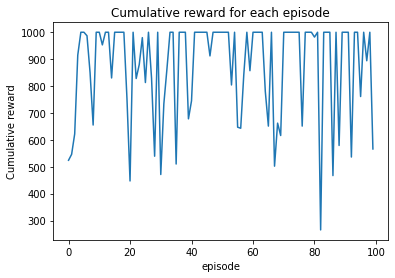

Average cumulative reward: 875.7
Is my agent good enough? True


In [ ]:
observation = env.reset()
agent = CartPoleQAgent(env, (1,1,6,12), 1000)
agent.train()

episode_results = []
showVideo = False
for i in range (100):
  episode_results.append(agent.run(showVideo))

#Plotting the cumulative reward for the different episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

total = sum(episode_results)
mean = total / (len(episode_results))
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

**Explanation for improvements**:
As observed, by tweaking the shape of the buckets array, it can lead to improvements to our results. As it turns out, the choice of the number and size of buckets is an important hyperparameter in the Q-value training process. 

Why so?
In the cartpole environment, these buckets refer to the discrete bins that the state variables (position, velocity, angle and angle velocity) are divided into. Dividing these states is a way to discretize the continuous states into finite set of states which makes Q-learning much easier to apply. 

By varying the shape of the buckets array, it affects the granularity of the state representation as well as the learning performance of our agent.

**Improvement #2**: We also realised that fixing the epsilon value and the learning rate may not yield an optimal solution. One possible way is to enforce an increasing decay rate (gamma) on those values to have them decrease at a faster rate, on top of increasing the bucket size.

This will incentivise the agent to take actions quickly as reward values will be even lower as episodes elapse.

In [ ]:
class CartPoleQAgentV2():
    def __init__(self,env=gym.make("CartPole-v1"), buckets=(1, 1, 6, 12), num_episodes=1000, min_lr=0.1, max_lr=0.95, min_epsilon=0.1, max_epsilon=0.95, discount=1.0):
        #number of discrete states for each observation
        self.buckets = buckets
        #number of episodes trained
        #Since the bucket size has increased, we increased the number of episodes trained so as to further fill up the bucket
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.discount = discount
        self.env = env
        self.env._max_episode_steps = 1000

        #upper bound and lower bound of observation space[position, velocity, angle, angular velocity]
        self.upper_bounds = [4.8, 1. , 0.418 , 1.]
        self.lower_bounds = [-4.8, -1. , -0.418 , -1.]

        #array with shape (1,1,6,11,2) (action_space=2)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))


    #we need to discretize states (which are continuous variable) since otherwise, it would take forever to get values for each of the possible combinations of each state
    def discretize_state(self, obs):
        discretized_obs_list = list()
        for i in range(len(obs)):
            ranging = (obs[i] - self.lower_bounds[i]) / (self.upper_bounds[i] - self.lower_bounds[i])
            discretized_obs = int(round((self.buckets[i] - 1) * ranging))
            discretized_obs = min(self.buckets[i] - 1, max(0, discretized_obs))

            discretized_obs_list.append(discretized_obs)
        return tuple(discretized_obs_list)

    #Referenced 2)
    #Applying randomness on the next action using the epsilon value to avoid biasness from previous values generated from previous states
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    #Updating the value of the state action pair using the Q-learning formula
    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    #Reducing the value of epsilon using an exponential function after every iteration of training to incentivise the agent to take actions quickly
    def get_epsilon(self, t):
        max_e_value = -math.log(self.max_epsilon,math.exp(1))
        min_e_value = -math.log(self.min_epsilon,math.exp(1))
        decay = (-1)*(max_e_value - (t/self.num_episodes)*(max_e_value-min_e_value))
        return math.exp(decay)

    #Reducing the value of gamma using an exponential function after every iteration of training to incentivise the agent to take actions quickly
    def get_learning_rate(self, t):
        max_e_value = -math.log(self.max_lr,math.exp(1))
        min_e_value = -math.log(self.min_lr,math.exp(1))
        decay = (-1)*(max_e_value - (t/self.num_episodes)*(max_e_value-min_e_value))
        return math.exp(decay)

    #Referenced 2)
    #Training the model based on set number of episodes to repeatedly update the Q values in the Q table using the generated action
    def train(self):
        for e in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())
            self.learning_rate = self.get_learning_rate(e)
            self.epsilon = self.get_epsilon(e)
            done = False

            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state

        print('Finished training!')

    #Running the agent after training, with rendering to display the episodes in a video
    def run(self,render):
        if render:
          self.env = RecordVideo(gym.make("CartPole-v1",),"./video2")
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                if render:
                  self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
        
        if render: 
          self.env.close()
          version = 2
          show_video(version)
        return t

Finished training!


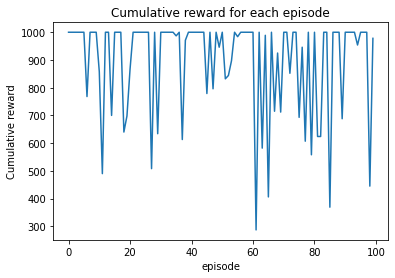

Average cumulative reward: 897.65
Is my agent good enough? True


In [ ]:
agentV2 = CartPoleQAgentV2()
agentV2.train()

#Initialising an array to store the different episodes generated
episode_results = []
showVideo = False
for i in range (100):
  episode_results.append(agentV2.run(showVideo))

#Plotting the cumulative reward for the different episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

total = sum(episode_results)
mean = total / (len(episode_results))
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

In [ ]:
showVideo = True
agentV2.run(showVideo)   


500

# Remarks
For the video, it may not be best representative of the results of our agent, since it only shows the observation of one episode out of the 100 episodes. The best metric should be the average cumulative reward, which our improved agent does better than our original agent with tweaked bucket sizes and decay rates. 

# References





1) https://medium.com/analytics-vidhya/q-learning-is-the-most-basic-form-of-reinforcement-learning-which-doesnt-take-advantage-of-any-8944e02570c5#:~:text=A%20CartPole%2Dv0%20is%20a,if%20the%20pole%20remains%20upright.

2) https://medium.com/@flomay/using-q-learning-to-solve-the-cartpole-balancing-problem-c0a7f47d3f9d

